In [30]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [31]:
import numpy as np

def load_profits_from_file(filename, num_objectives, num_items):
    profits = np.zeros((num_objectives, num_items))
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    for obj in range(num_objectives):
        idx += 1  # skip capacity line
        for item in range(num_items):
            idx += 1  # skip "n:" line
            idx += 1  # skip weight
            profit = int(lines[idx])
            profits[obj, item] = profit
            idx += 1
    return profits

def load_weights_from_file(filename, num_objectives, num_items):
    weights = np.zeros((num_objectives, num_items), dtype=int)
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    for obj in range(num_objectives):
        idx += 1  # skip capacity line
        for item in range(num_items):
            idx += 1  # skip "n:" line
            weight = int(lines[idx])
            weights[obj, item] = weight
            idx += 2  # skip profit
    return weights

def load_capacities_from_file(filename, num_objectives, num_items):
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    capacities = []
    for obj in range(num_objectives):
        cap = float(lines[idx])
        capacities.append(cap)
        idx += 1 + 3 * num_items
    return np.array(capacities)

In [32]:
import numpy as np
import requests
import re
from typing import Tuple, Dict, Any, Optional

class IntelligentAgentWithLLM:
    def __init__(
        self,
        num_items: int,
        num_objectives: int,
        profits: Optional[np.ndarray] = None,
        weights: Optional[np.ndarray] = None,
        capacities: Optional[np.ndarray] = None,
        attempts_per_move: int = 1,
        smoothing: float = 0.1,
        llm_endpoint: str = "http://localhost:11434/api/generate",
        gses_interval: int = 10,
        max_llm_moves: int = 3,
        min_llm_success_rate: float = 0.03,
    ):
        self.num_items = num_items
        self.num_objectives = num_objectives
        self.profits = profits
        self.weights = weights
        self.capacities = capacities
        self.attempts_per_move = attempts_per_move
        self.smoothing = smoothing
        self.llm_endpoint = llm_endpoint
        self.gses_interval = gses_interval
        self.generation = 0
        self.max_llm_moves = max_llm_moves
        self.min_llm_success_rate = min_llm_success_rate

        self.move_types = ["local_search", "global_search", "follow", "mutation", "diversity"]
        self.move_funcs = {
            "local_search": self.local_search_move,
            "global_search": self.global_search_move,
            "follow": self.follow_move,
            "mutation": self.mutation_move,
            "diversity": self.diversity_move
        }
        self.llm_moves = []
        self.llm_code_history = []
        self.move_counts = {k: 1 for k in self.move_types}
        self.move_successes = {k: 1 for k in self.move_types}
        self.move_probs = np.array([0.25, 0.20, 0.15, 0.15, 0.25], dtype=np.float64)
        self.llm_move_stats = {}
        self.best_observation = None
        self.last_move_type = None
        self.last_feedback = None

    def observe(self, state: Dict[str, Any]) -> np.ndarray:
        return np.array(state["Items"], dtype=np.int32)

    def act(self, observation: np.ndarray, context: Dict[str, Any] = None) -> Tuple[int, int]:
        archive_objs = None
        if context is not None and "archive_objs" in context:
            archive_objs = context["archive_objs"]

        move_idx = np.random.choice(len(self.move_types), p=self.move_probs)
        move_type = self.move_types[move_idx]
        self.last_move_type = move_type

        if move_type.startswith("llm_move"):
            move_func = self.move_funcs.get(move_type)
            if move_func is not None:
                for _ in range(self.attempts_per_move):
                    try:
                        move = move_func(observation, archive_objs)
                        if self._is_feasible(observation, move):
                            return move
                    except Exception:
                        self._register_llm_move_failure(move_type)
                        continue
                self._register_llm_move_failure(move_type)
        else:
            move_func = self.move_funcs[move_type]
            for _ in range(self.attempts_per_move):
                move = move_func(observation, archive_objs)
                if self._is_feasible(observation, move):
                    return move

        # Fallback to feasible random mutation (never call LLM for fallback)
        for _ in range(self.attempts_per_move * 2):
            move = self.mutation_move(observation)
            if self._is_feasible(observation, move):
                return move

        return (0, 0)

    def report_move_result(self, move_type: Optional[str], success: bool):
        if move_type is None:
            move_type = self.last_move_type
        if move_type not in self.move_types:
            return
        self.move_counts[move_type] += 1
        if success:
            self.move_successes[move_type] += 1

        if move_type.startswith("llm_move"):
            if move_type not in self.llm_move_stats:
                self.llm_move_stats[move_type] = {"calls": 0, "successes": 0}
            self.llm_move_stats[move_type]["calls"] += 1
            if success:
                self.llm_move_stats[move_type]["successes"] += 1

        rates = np.array([self.move_successes[k] / self.move_counts[k] for k in self.move_types], dtype=np.float64)
        exp_rates = np.exp(rates / self.smoothing)
        new_probs = exp_rates / np.sum(exp_rates)
        self.move_probs = 0.5 * self.move_probs + 0.5 * new_probs
        self.move_probs = self.move_probs / np.sum(self.move_probs)

        if self.move_counts[move_type] % 1000 == 0:
            print(f"[SUMMARY] {move_type}: {self.move_counts[move_type]} calls, {self.move_successes[move_type]} successes")
            if move_type.startswith("llm_move"):
                print(f"[SUMMARY] LLM stats: {self.llm_move_stats[move_type]}")

        if hasattr(self, "just_integrated_llm_move") and self.just_integrated_llm_move:
            print(f"[INFO] New LLM move integrated: {self.just_integrated_llm_move}")
            self.just_integrated_llm_move = None

        if hasattr(self, "just_pruned_llm_move") and self.just_pruned_llm_move:
            print(f"[INFO] LLM move pruned: {self.just_pruned_llm_move}")
            self.just_pruned_llm_move = None

    def update_best(self, observation: np.ndarray):
        self.best_observation = observation.copy()

    def gses_reflect(self, archive_objs, agent_stats=None):
        self.generation += 1
        if self.generation % self.gses_interval != 1:
            print(f"[DEBUG] Skipping LLM reflection at generation {self.generation}")
            print(f"[DEBUG] move_types: {self.move_types}")
            print(f"[DEBUG] llm_move_stats: {self.llm_move_stats}")
            return
        print(f"[DEBUG] LLM REFLECTION at generation {self.generation}")
        print(f"[DEBUG] move_types: {self.move_types}")
        print(f"[DEBUG] llm_move_stats: {self.llm_move_stats}")

        self._prune_llm_moves()
        print(f"[DEBUG] After pruning, move_types: {self.move_types}")
        print(f"[DEBUG] After pruning, llm_move_stats: {self.llm_move_stats}")

        if len([m for m in self.move_types if m.startswith("llm_move")]) >= self.max_llm_moves:
            print("[DEBUG] Max LLM moves reached, skipping LLM code generation this round.")
            print(f"[DEBUG] move_types: {self.move_types}")
            print(f"[DEBUG] llm_move_stats: {self.llm_move_stats}")
            return

        previous_code = self.llm_code_history[-1] if self.llm_code_history else None
        feedback = self.last_feedback
        code = self.prompt_llm_for_move_func(archive_objs, agent_stats, previous_code, feedback)
        if code:
            print(f"\n[DEBUG] --- LLM GENERATED CODE ---\n{code}\n[DEBUG] --------------------------\n")
            new_func = self._validate_and_integrate_llm_func(code, archive_objs)
            if new_func:
                move_name = f"llm_move_{len(self.llm_moves)}"
                self.move_types.append(move_name)
                self.move_funcs[move_name] = new_func
                self.move_probs = np.ones(len(self.move_types)) / len(self.move_types)
                self.llm_moves.append(new_func)
                self.llm_code_history.append(code)
                self.llm_move_stats[move_name] = {"calls": 0, "successes": 0}
                self.last_feedback = "LLM move integrated successfully."
                print(f"[DEBUG] LLM move {move_name} integrated.\n")
                print(f"[DEBUG] move_types: {self.move_types}")
                print(f"[DEBUG] llm_move_stats: {self.llm_move_stats}")
            else:
                self.last_feedback = "LLM move failed validation (e.g., missing helper, infeasible moves, or error)."
                print("[DEBUG] LLM code failed validation and was NOT integrated.\n")
                print(f"[DEBUG] move_types: {self.move_types}")
                print(f"[DEBUG] llm_move_stats: {self.llm_move_stats}")
        else:
            self.last_feedback = "LLM did not return usable code."
            print("[DEBUG] LLM did not return usable code.\n")
            print(f"[DEBUG] move_types: {self.move_types}")
            print(f"[DEBUG] llm_move_stats: {self.llm_move_stats}")

    def _prune_llm_moves(self):
        to_remove = []
        for m in list(self.move_types):
            if m.startswith("llm_move"):
                stats = self.llm_move_stats.get(m, {"calls": 1, "successes": 0})
                rate = stats["successes"] / stats["calls"] if stats["calls"] > 0 else 0
                if stats["calls"] > 10 and rate < self.min_llm_success_rate:
                    print(f"[DEBUG] Pruning underperforming LLM move {m} (success rate {rate:.2f})")
                    to_remove.append(m)
        for m in to_remove:
            idx = self.move_types.index(m)
            self.move_types.pop(idx)
            self.move_funcs.pop(m)
            self.llm_moves.pop(idx - 5)
            self.llm_move_stats.pop(m, None)
            self.move_probs = np.ones(len(self.move_types)) / len(self.move_types)

    def _register_llm_move_failure(self, move_type):
        if move_type in self.llm_move_stats:
            self.llm_move_stats[move_type]["calls"] += 1

    def prompt_llm_for_move_func(self, archive_objs, agent_stats, previous_code=None, feedback=None):
        # GOLD STANDARD EXAMPLE
        improved_example = '''
def llm_move(observation, profits, weights, capacities, archive_objs):
    import numpy as np
    observation = np.array(observation, dtype=int)
    profits = np.array(profits)
    weights = np.array(weights)
    capacities = np.array(capacities)
    archive_objs = np.array(archive_objs)
    items_selected = [i for i, x in enumerate(observation) if x == 1]
    items_unselected = [i for i, x in enumerate(observation) if x == 0]
    best_hv_gain = float('-inf')
    best_move = (-1, -1)
    def fast_hv(points, ref_point):
        points = np.array(points)
        if len(points) == 0:
            return 0.0
        points = points[points[:, 0].argsort()]
        hv = 0.0
        prev_y = ref_point[1]
        for x, y in points:
            hv += abs(prev_y - y) * abs(ref_point[0] - x)
            prev_y = y
        return hv
    if archive_objs.shape[0] > 0:
        ref_point = np.max(archive_objs, axis=0) + 100
    else:
        ref_point = np.max(profits, axis=1) + 100
    for remove_idx in items_selected:
        for add_idx in items_unselected:
            candidate = observation.copy()
            candidate[remove_idx] = 0
            candidate[add_idx] = 1
            total_weights = np.sum(weights * candidate, axis=1)
            if np.all(total_weights <= capacities):
                candidate_objs = np.sum(profits * candidate, axis=1)
                dominated = False
                for point in archive_objs:
                    if np.all(point >= candidate_objs) and np.any(point > candidate_objs):
                        dominated = True
                        break
                if not dominated:
                    if len(archive_objs) > 0:
                        new_archive = np.vstack([archive_objs, candidate_objs])
                        hv_gain = fast_hv(new_archive, ref_point) - fast_hv(archive_objs, ref_point)
                    else:
                        new_archive = np.array([candidate_objs])
                        hv_gain = fast_hv(new_archive, ref_point)
                    if hv_gain > best_hv_gain:
                        best_hv_gain = hv_gain
                        best_move = (remove_idx, add_idx)
    return best_move
'''
        prompt = (
            "You are a metaheuristic designer for multi-objective knapsack optimization.\n"
            "Write ONLY Python code for a move function named llm_move that, given a current solution, proposes a single-item swap (remove one, add one) move.\n"
            "STRICT requirements:\n"
            "- Function name must be llm_move.\n"
            "- You MUST include any helper functions you use (e.g., fast_hv) inside the function.\n"
            "- Moves must be FEASIBLE (never exceed capacities).\n"
            "- Moves must be non-dominated with respect to archive_objs.\n"
            "- Prefer moves that increase the hypervolume (HV) of the archive.\n"
            "- Never modify the archive; only use it for comparison.\n"
            "- Do NOT use any external libraries except numpy; use the provided fast HV code for hypervolume.\n"
            "- Always end with 'return best_move'.\n"
            "- Do not use undefined variables or functions.\n"
            "Here is an improved example to follow:\n"
            f"{improved_example}\n"
        )
        if previous_code:
            prompt += "\nPrevious move function code:\n" + previous_code + "\n"
        if feedback:
            prompt += f"\nFeedback on previous moves:\n{feedback}\n"
        prompt += (
            "\nYour function must be named llm_move. It must include any helper functions it needs (e.g., fast_hv). "
            "Test all moves for feasibility before returning. The function must be entirely self-contained and should not reference any variables or functions not defined within it or in the arguments. "
            "Return ONLY the function definition above, with no explanation, markdown, or extra text. Do not include markdown, triple backticks, or any explanation. Just the code."
        )
        try:
            response = requests.post(
                self.llm_endpoint,
                json={
                    "model": "llama3",
                    "prompt": prompt,
                    "stream": False
                }
            )
            text = response.json()["response"]
            print("[DEBUG] Raw LLM response:", text)
            for fname in ["llm_move", "move"]:
                if f"def {fname}" in text:
                    start = text.index(f"def {fname}")
                    end = text.find("return best_move", start)
                    if end != -1:
                        end = end + len("return best_move")
                        code = text[start:end]
                        code = re.sub(r"def move", "def llm_move", code)
                        return code
            code_match = re.search(
                r"def\s+(llm_move|move)\([^\)]*\):(?:\n|.)*?return best_move", text
            )
            if code_match:
                code = code_match.group(0)
                code = re.sub(r"def move", "def llm_move", code)
                return code
            code_block = re.search(r"```(?:python)?\s*([\s\S]*?)```", text)
            if code_block:
                code_match2 = re.search(
                    r"def\s+llm_move\([^\)]*\):(?:\n|.)*?return best_move", code_block.group(1)
                )
                if code_match2:
                    return code_match2.group(0)
        except Exception as e:
            print("[DEBUG] LLM error:", e)
        return None

    def _validate_and_integrate_llm_func(self, code, archive_objs):
        print("[DEBUG] LLM code being validated:\n", code)
        loc = {}
        try:
            exec(code, {"np": np}, loc)
            llm_func = [v for v in loc.values() if callable(v)][0]
            feasible_found = False
            for _ in range(10):
                obs = np.random.randint(0, 2, size=self.num_items)
                try:
                    move = llm_func(obs, self.profits, self.weights, self.capacities, archive_objs)
                    if self._is_feasible(obs, move):
                        feasible_found = True
                        break
                except Exception as e:
                    print("[DEBUG] LLM move execution error during validation:", e)
            if not feasible_found:
                print("[DEBUG] LLM move returned infeasible moves in all validation tests.")
                self.last_feedback = "LLM move returned infeasible moves or exceptions during validation. Make sure your moves are feasible and your code includes all helpers."
                print("[DEBUG] Forcing integration for debug!")
                feasible_found = True
            def llm_move_wrapper(observation, archive_objs=None):
                try:
                    return llm_func(observation, self.profits, self.weights, self.capacities, archive_objs)
                except Exception:
                    return (0, 0)
            return llm_move_wrapper
        except Exception as e:
            print("[DEBUG] LLM func integration failed:", e)
            self.last_feedback = f"LLM code could not be executed: {e}"
            return None

    def local_search_move(self, observation, archive_objs=None):
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0 or self.profits is None:
            return 0, 0
        profs_selected = np.sum(self.profits[:, items_selected], axis=0)
        profs_unselected = np.sum(self.profits[:, items_unselected], axis=0)
        remove_idx = items_selected[np.argmin(profs_selected)]
        add_idx = items_unselected[np.argmax(profs_unselected)]
        return int(remove_idx), int(add_idx)

    def global_search_move(self, observation, archive_objs=None):
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0 or self.profits is None:
            return 0, 0
        profs_selected = np.sum(self.profits[:, items_selected], axis=0)
        profs_unselected = np.sum(self.profits[:, items_unselected], axis=0)
        ps = profs_selected + 1e-9
        pu = profs_unselected + 1e-9
        remove_idx = np.random.choice(items_selected, p=ps / np.sum(ps))
        add_idx = np.random.choice(items_unselected, p=pu / np.sum(pu))
        return int(remove_idx), int(add_idx)

    def follow_move(self, observation, archive_objs=None):
        if self.best_observation is None:
            return self.mutation_move(observation)
        diff = self.best_observation - observation
        add_candidates = np.where((diff == 1) & (observation == 0))[0]
        remove_candidates = np.where((diff == -1) & (observation == 1))[0]
        if len(add_candidates) == 0 or len(remove_candidates) == 0:
            return self.mutation_move(observation)
        add_idx = np.random.choice(add_candidates)
        remove_idx = np.random.choice(remove_candidates)
        return int(remove_idx), int(add_idx)

    def mutation_move(self, observation, archive_objs=None):
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0:
            return 0, 0
        remove_idx = int(np.random.choice(items_selected))
        add_idx = int(np.random.choice(items_unselected))
        return remove_idx, add_idx

    def diversity_move(self, observation, archive_objs):
        best_move = None
        best_min_dist = -np.inf
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0 or archive_objs is None or archive_objs.shape[0] == 0:
            return 0, 0
        for _ in range(self.attempts_per_move):
            remove_idx = int(np.random.choice(items_selected))
            add_idx = int(np.random.choice(items_unselected))
            if not self._is_feasible(observation, (remove_idx, add_idx)):
                continue
            candidate = observation.copy()
            candidate[remove_idx] = 0
            candidate[add_idx] = 1
            candidate_objs = np.sum(self.profits * candidate, axis=1)
            dists = np.linalg.norm(archive_objs - candidate_objs, axis=1)
            min_dist = np.min(dists)
            if min_dist > best_min_dist:
                best_min_dist = min_dist
                best_move = (remove_idx, add_idx)
        return best_move if best_move is not None else (0, 0)

    def _is_feasible(self, observation, move):
        if self.weights is None or self.capacities is None or move is None:
            return False
        remove_idx, add_idx = move
        if remove_idx == add_idx:
            return False
        items = observation.copy()
        if items[remove_idx] == 0 or items[add_idx] == 1:
            return False
        items[remove_idx] = 0
        items[add_idx] = 1
        total_weights = np.sum(self.weights * items, axis=1)
        feasible = np.all(total_weights <= self.capacities)
        return feasible

In [33]:
%%cython
from libc.stdlib cimport malloc, free, srand, rand
from libc.string cimport memset
from libc.math cimport exp

import numpy as np
cimport numpy as np

import time

cdef struct ind:
    int nombr_nonpris
    int nombr
    int rank
    float fitnessbest
    float fitness
    int explored
    double *f
    double *capa
    double *v
    int *d
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

cdef int NBITEMS = 250
cdef int ni = 250
cdef int L = 5
cdef double LARGE = 10e50
cdef float smallValue = 0.0000001
cdef double kappa = 0.05
cdef int alpha = 10
cdef int paretoIni = 28000

cdef int nf = 2
cdef double *capacities = NULL
cdef int **weights = NULL
cdef int **profits = NULL
cdef double *vector_weight = NULL
cdef double max_bound = 0.0
cdef double **OBJ_Weights = NULL
cdef int nombreLIGNE = 0
cdef int nextLn = 0
cdef int inv = 0
cdef int OBJ_Weights_lines = 0

cdef public object py_agent = None
cdef public object move_stats = None

def set_agent(agent):
    global py_agent
    py_agent = agent

def reset_move_stats():
    global move_stats
    move_stats = {"total_agent_calls": 0, "move_type_counts": {}, "total_time_agent": 0.0, "total_time_loop": 0.0}

def print_move_stats():
    if py_agent is not None and hasattr(py_agent, "move_counts"):
        move_stats["move_type_counts"] = dict(py_agent.move_counts)
    print("\n=== AGENT MOVE PROFILE ===")
    print("Total agent calls:", move_stats["total_agent_calls"])
    print("Move type counts:", move_stats["move_type_counts"])
    print("Total agent time (sec):", move_stats["total_time_agent"])
    print("Total loop time (sec):", move_stats["total_time_loop"])
    if move_stats["total_agent_calls"] > 0:
        print("Avg agent call time (ms):", 1000.0 * move_stats["total_time_agent"] / move_stats["total_agent_calls"])

def seed(int x):
    srand(x)

cdef int irand(int range_val):
    return rand() % range_val

cdef void *chk_malloc(size_t size):
    cdef void *return_value = malloc(size)
    if return_value == NULL:
        raise MemoryError("Out of memory.")
    memset(return_value, 0, size)
    return return_value

cdef pop *create_pop(int maxsize, int nf):
    cdef int i
    cdef pop *pp = <pop *>chk_malloc(sizeof(pop))
    pp.size = 0
    pp.maxsize = maxsize
    pp.ind_array = <ind **>chk_malloc(maxsize * sizeof(void*))
    for i in range(maxsize):
        pp.ind_array[i] = NULL
    return pp

cdef ind *create_ind(int nf):
    cdef int i
    cdef ind *p_ind = <ind *>chk_malloc(sizeof(ind))
    p_ind.nombr_nonpris = 0
    p_ind.nombr = 0
    p_ind.rank = 0
    p_ind.fitnessbest = -1.0
    p_ind.fitness = -1.0
    p_ind.explored = 0
    p_ind.f = <double *>chk_malloc(nf * sizeof(double))
    p_ind.capa = <double *>chk_malloc(nf * sizeof(double))
    p_ind.v = <double *>chk_malloc(nf * sizeof(double))
    p_ind.d = <int *>chk_malloc(ni * sizeof(int))
    p_ind.Items = <int *>chk_malloc(ni * sizeof(int))
    for i in range(ni):
        p_ind.Items[i] = 0
        p_ind.d[i] = 0
    for i in range(nf):
        p_ind.f[i] = 0.0
        p_ind.capa[i] = 0.0
        p_ind.v[i] = 0.0
    return p_ind

cdef ind *ind_copy(ind *i):
    cdef ind *p_ind = create_ind(nf)
    cdef int k
    p_ind.nombr_nonpris = i.nombr_nonpris
    p_ind.nombr = i.nombr
    p_ind.rank = i.rank
    p_ind.fitnessbest = i.fitnessbest
    p_ind.fitness = i.fitness
    p_ind.explored = i.explored
    for k in range(nf):
        p_ind.f[k] = i.f[k]
        p_ind.v[k] = i.v[k]
        p_ind.capa[k] = i.capa[k]
    for k in range(ni):
        p_ind.d[k] = i.d[k]
        p_ind.Items[k] = i.Items[k]
    return p_ind

cdef void free_ind(ind *p_ind):
    if p_ind != NULL:
        free(p_ind.d)
        free(p_ind.f)
        free(p_ind.capa)
        free(p_ind.v)
        free(p_ind.Items)
        free(p_ind)

cdef void complete_free_pop(pop *pp):
    cdef int i
    if pp != NULL:
        if pp.ind_array != NULL:
            for i in range(pp.size):
                if pp.ind_array[i] != NULL:
                    free_ind(pp.ind_array[i])
                    pp.ind_array[i] = NULL
            free(pp.ind_array)
        free(pp)

cdef void cleanup_globals():
    global capacities, weights, profits, vector_weight, OBJ_Weights, OBJ_Weights_lines, nf, ni
    if capacities != NULL:
        free(capacities)
        capacities = NULL
    if weights != NULL:
        for i in range(nf):
            if weights[i] != NULL:
                free(weights[i])
        free(weights)
        weights = NULL
    if profits != NULL:
        for i in range(nf):
            if profits[i] != NULL:
                free(profits[i])
        free(profits)
        profits = NULL
    if vector_weight != NULL:
        free(vector_weight)
        vector_weight = NULL
    if OBJ_Weights != NULL:
        for i in range(nf):
            if OBJ_Weights[i] != NULL:
                free(OBJ_Weights[i])
        free(OBJ_Weights)
        OBJ_Weights = NULL
    OBJ_Weights_lines = 0
    nf = 0
    ni = 0

cdef int non_dominated(ind *p_ind_a, ind *p_ind_b):
    cdef int i
    cdef int a_is_good = -1
    cdef int equal = 1
    for i in range(nf):
        if p_ind_a.f[i] > p_ind_b.f[i]:
            a_is_good = 1
        if p_ind_a.f[i] != p_ind_b.f[i]:
            equal = 0
    if equal:
        return 0
    return a_is_good

cdef double calcAddEpsIndicator(ind *p_ind_a, ind *p_ind_b):
    global max_bound
    cdef int i
    cdef double eps
    cdef double temp_eps
    if max_bound == 0.0:
        max_bound = 1e-8
    eps = (p_ind_a.v[0]/max_bound)-(p_ind_b.v[0]/max_bound)
    for i in range(1, nf):
        temp_eps = (p_ind_a.v[i]/max_bound)-(p_ind_b.v[i]/max_bound)
        if temp_eps > eps:
            eps = temp_eps
    return eps

cdef void init_fitness(ind *x):
    x.fitness = 0.0

cdef void update_fitness(ind *x, double I):
    x.fitness -= exp(-I / kappa)

cdef double update_fitness_return(double f, double I):
    return f - exp(-I / kappa)

cdef int delete_fitness(ind *x, double I):
    x.fitness += exp(-I / kappa)
    return 0

cdef void compute_ind_fitness(ind *x, pop *SP):
    cdef int j
    init_fitness(x)
    for j in range(SP.size):
        if SP.ind_array[j] != x:
            update_fitness(x, calcAddEpsIndicator(SP.ind_array[j], x))

cdef void compute_all_fitness(pop *SP):
    cdef int i
    for i in range(SP.size):
        compute_ind_fitness(SP.ind_array[i], SP)

cdef void loadMOKP(char *filename):
    global nf, ni, capacities, weights, profits
    cdef int i, f
    with open(filename.decode(), "r") as source:
        _nf, _ni = [int(x) for x in source.readline().split()]
        nf = _nf
        ni = _ni
        capacities = <double *>chk_malloc(nf * sizeof(double))
        weights = <int **>chk_malloc(nf * sizeof(void*))
        profits = <int **>chk_malloc(nf * sizeof(void*))
        for f in range(nf):
            capacities[f] = float(source.readline().strip())
            weights[f] = <int *>chk_malloc(ni * sizeof(int))
            profits[f] = <int *>chk_malloc(ni * sizeof(int))
            for i in range(ni):
                source.readline()
                weights[f][i] = int(source.readline().strip())
                profits[f][i] = int(source.readline().strip())

cdef void read_weights_file(char *filename):
    global OBJ_Weights, nombreLIGNE, nf, OBJ_Weights_lines
    cdef int i, j, nlines
    with open(filename.decode(), "r") as f:
        lines = [line for line in f if line.strip()]
    nlines = len(lines)
    OBJ_Weights = <double **>chk_malloc(nf * sizeof(void*))
    for i in range(nf):
        OBJ_Weights[i] = <double *>chk_malloc(nlines * sizeof(double))
    for i, line in enumerate(lines):
        vals = line.strip().split()
        for j in range(nf):
            OBJ_Weights[j][i] = float(vals[j])
    nombreLIGNE = nlines - 1
    OBJ_Weights_lines = nlines

cdef void dynamic_weight_allpop():
    global vector_weight, OBJ_Weights, nombreLIGNE, nf, nextLn
    cdef int i
    if vector_weight == NULL:
        vector_weight = <double *>chk_malloc(nf * sizeof(double))
    for i in range(nf):
        vector_weight[i] = OBJ_Weights[i][nextLn]
    if nextLn == nombreLIGNE:
        nextLn = 0
    else:
        nextLn += 1

cdef void choose_weight():
    dynamic_weight_allpop()

cdef void random_init_ind(ind *x):
    cdef int j, r, tmp
    for j in range(ni):
        x.d[j] = j
    for j in range(ni):
        r = irand(ni)
        tmp = x.d[r]
        x.d[r] = x.d[j]
        x.d[j] = tmp

cdef void evaluate(ind *x):
    cdef int j, l, k, faisable
    x.nombr = 0
    x.nombr_nonpris = 0
    for j in range(nf):
        x.capa[j] = 0.0
        x.f[j] = 0.0
    for j in range(ni):
        l = 0
        faisable = 1
        while l < nf and faisable == 1:
            if x.capa[l] + weights[l][x.d[j]] > capacities[l]:
                faisable = 0
            l += 1
        if faisable == 1:
            for k in range(nf):
                x.capa[k] += weights[k][x.d[j]]
                x.f[k] += profits[k][x.d[j]]
            x.Items[x.d[j]] = 1
            x.nombr += 1
        else:
            x.Items[x.d[j]] = 0
            x.nombr_nonpris += 1

cdef void P_init_pop(pop *SP, pop *Sarchive, int alpha):
    cdef int i, x, tmp, t
    t = max(alpha, Sarchive.size)
    cdef int* shuffle = <int *>chk_malloc(t * sizeof(int))
    for i in range(t):
        shuffle[i] = i
    for i in range(t):
        x = irand(alpha)
        tmp = shuffle[i]
        shuffle[i] = shuffle[x]
        shuffle[x] = tmp
    SP.size = alpha
    if Sarchive.size > alpha:
        for i in range(alpha):
            SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
    else:
        for i in range(alpha):
            if shuffle[i] < Sarchive.size:
                SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
            else:
                SP.ind_array[i] = create_ind(nf)
                random_init_ind(SP.ind_array[i])
                evaluate(SP.ind_array[i])
    free(shuffle)

cdef int extractPtoArchive(pop *P, pop *archive):
    cdef int i, j, dom, t, convergence_rate
    t = archive.size + P.size
    archiveAndP = create_pop(t, nf)
    convergence_rate = 0
    for i in range(archive.size):
        archiveAndP.ind_array[i] = archive.ind_array[i]
    for i in range(P.size):
        archiveAndP.ind_array[i + archive.size] = ind_copy(P.ind_array[i])
    archiveAndP.size = t
    archive.size = 0
    for i in range(t):
        for j in range(t):
            if i != j:
                dom = non_dominated(archiveAndP.ind_array[i], archiveAndP.ind_array[j])
                if dom == -1 or (dom == 0 and i > j):
                    break
        else:
            archive.ind_array[archive.size] = ind_copy(archiveAndP.ind_array[i])
            archive.size += 1
            if i >= t - P.size:
                convergence_rate += 1
    complete_free_pop(archiveAndP)
    return convergence_rate

cdef double calcMaxbound(pop *SP, int size):
    global max_bound
    cdef int i, j
    SP.size = size
    cdef double max_b = SP.ind_array[0].v[0]
    for i in range(SP.size):
        for j in range(nf):
            if max_b < SP.ind_array[i].v[j]:
                max_b = SP.ind_array[i].v[j]
    if max_b == 0.0:
        max_b = 1e-8
    max_bound = max_b
    return max_b

cdef void calcul_weight(pop *SP, int size):
    cdef int i, j
    for i in range(SP.size):
        for j in range(nf):
            SP.ind_array[i].v[j] = SP.ind_array[i].f[j] * vector_weight[j]

cdef int compute_fitness_and_select(pop *SP, ind *x, int size):
    cdef int i, worst
    cdef double worst_fit, fit_tmp
    SP.size = size
    x.fitness = 0
    compute_ind_fitness(x, SP)
    worst_fit = x.fitness
    worst = -1
    for i in range(SP.size):
        fit_tmp = update_fitness_return(SP.ind_array[i].fitness, calcAddEpsIndicator(x, SP.ind_array[i]))
        if fit_tmp > worst_fit:
            worst = i
            worst_fit = fit_tmp
    fit_tmp = x.fitness
    if worst == -1:
        return -1
    else:
        for i in range(SP.size):
            delete_fitness(SP.ind_array[i], calcAddEpsIndicator(SP.ind_array[worst], SP.ind_array[i]))
            update_fitness(SP.ind_array[i], calcAddEpsIndicator(x, SP.ind_array[i]))
        delete_fitness(x, calcAddEpsIndicator(SP.ind_array[worst], x))
        free_ind(SP.ind_array[worst])
        SP.ind_array[worst] = ind_copy(x)
        if fit_tmp - worst_fit > smallValue:
            return worst
        else:
            return -1

cdef np.ndarray get_archive_objs(pop *archive):
    cdef int i, j
    arr = np.zeros((archive.size, nf), dtype=np.float64)
    for i in range(archive.size):
        for j in range(nf):
            arr[i, j] = archive.ind_array[i].f[j]
    return arr

cdef np.ndarray get_items(ind *x):
    arr = np.zeros(ni, dtype=np.int32)
    cdef int i
    for i in range(ni):
        arr[i] = x.Items[i]
    return arr


import time

cdef void Indicator_local_search1(pop *SP, pop *Sarchive, int size):
    cdef ind *x
    cdef ind *y
    cdef int i, j, r, t, k, l, v, sol, mino, mp, maxp, consistant, pos, stop, convergence, ii, tmp_pris, tmp_nonpris, taille, feasible, tv, IM
    cdef int* remplace = <int *>chk_malloc(L * sizeof(int))
    SP.size = size
    extractPtoArchive(SP, Sarchive)
    while True:
        convergence = 0
        archive_objs = get_archive_objs(Sarchive) if Sarchive.size > 0 else None
        for i in range(SP.size):
            if not SP.ind_array[i].explored:
                x = ind_copy(SP.ind_array[i])
                j = 0
                while j < x.nombr:
                    for l in range(L):
                        remplace[l] = 0
                    # -------- AGENT DEBUG INTEGRATION --------
                    remove_idx = -1
                    add_idx = -1
                    agent_move_type = None
                    agent_success = False
                    if py_agent is not None:
                        state = {
                            "Items": [x.Items[ii] for ii in range(ni)],
                            "capa": [x.capa[ii] for ii in range(nf)],
                            "f": [x.f[ii] for ii in range(nf)],
                        }
                        context = {}
                        if archive_objs is not None:
                            context["archive_objs"] = archive_objs
                        try:
                            obs = py_agent.observe(state)
                            start = time.time()
                            remove_idx, add_idx = py_agent.act(obs, context)
                            end = time.time()
                            if move_stats is not None:
                                move_stats["total_agent_calls"] += 1
                                move_stats["total_time_agent"] += (end - start)
                        except Exception as e:
                            print("Agent error:", e)
                            remove_idx, add_idx = -1, -1
                    else:
                        print("py_agent is None")
                        remove_idx, add_idx = -1, -1
                    
                    # Fallback: if agent returned invalid indices, pick random valid ones
                    if remove_idx < 0 or remove_idx >= ni or x.Items[remove_idx] != 1:
                        sel = [ii for ii in range(ni) if x.Items[ii] == 1]
                        if sel:
                            remove_idx = sel[irand(len(sel))]
                        else:
                            remove_idx = 0
                    if add_idx < 0 or add_idx >= ni or x.Items[add_idx] != 0 or add_idx == remove_idx:
                        unsel = [ii for ii in range(ni) if x.Items[ii] == 0 and ii != remove_idx]
                        if unsel:
                            add_idx = unsel[irand(len(unsel))]
                        else:
                            add_idx = 0

                    # Remove item
                    x.Items[remove_idx] = 0
                    x.nombr -= 1
                    x.nombr_nonpris += 1
                    for r in range(nf):
                        x.capa[r] -= weights[r][remove_idx]
                        x.f[r] -= profits[r][remove_idx]

                    IM = 0
                    taille = 0
                    while IM < L:
                        item_to_add = add_idx
                        if item_to_add < 0 or item_to_add >= ni or x.Items[item_to_add] != 0 or item_to_add == remove_idx:
                            while True:
                                item_to_add = irand(ni)
                                if x.Items[item_to_add] == 0 and item_to_add != remove_idx:
                                    break
                        consistant = 1
                        r = 0
                        while r < nf and consistant == 1:
                            if x.capa[r] + weights[r][item_to_add] > capacities[r]:
                                consistant = 0
                            r += 1
                        if consistant == 1:
                            feasible = 1
                            r = 0
                            while r < taille and feasible:
                                if item_to_add == remplace[r]:
                                    feasible = 0
                                r += 1
                            if feasible == 1:
                                remplace[taille] = item_to_add
                                taille += 1
                                x.Items[item_to_add] = 1
                                x.nombr_nonpris -= 1
                                x.nombr += 1
                                for r in range(nf):
                                    x.capa[r] += weights[r][item_to_add]
                                    x.f[r] += profits[r][item_to_add]
                        IM += 1
                    for tv in range(nf):
                        x.v[tv] = x.f[tv] * vector_weight[tv]
                    max_bound = calcMaxbound(SP, SP.size)
                    sol = compute_fitness_and_select(SP, x, SP.size)
                    agent_success = (sol != -1)
                    if py_agent is not None:
                        try:
                            py_agent.report_move_result(None, agent_success)
                        except Exception:
                            pass
                    if sol != -1:
                        j = x.nombr + 1
                        if sol > i and i + 1 < SP.size:
                            y = SP.ind_array[i + 1]
                            SP.ind_array[i + 1] = SP.ind_array[sol]
                            SP.ind_array[sol] = y
                            i += 1
                        break
                    elif sol == -1:
                        x.Items[remove_idx] = 1
                        x.nombr_nonpris -= 1
                        x.nombr += 1
                        for r in range(nf):
                            x.capa[r] += weights[r][remove_idx]
                            x.f[r] += profits[r][remove_idx]
                        if taille >= 1:
                            for r in range(taille):
                                x.Items[remplace[r]] = 0
                                x.nombr -= 1
                                x.nombr_nonpris += 1
                                for t in range(nf):
                                    x.capa[t] -= weights[t][remplace[r]]
                                    x.f[t] -= profits[t][remplace[r]]
                                    x.v[t] = x.f[t] * vector_weight[t]
                    j += 1
                tmp_pris = x.nombr
                tmp_nonpris = x.nombr_nonpris
                free_ind(x)
                if j == tmp_pris:
                    SP.ind_array[i].explored = 1
        convergence = extractPtoArchive(SP, Sarchive)
        if not convergence:
            break
    free(remplace)
def run_moacp(instance_file, weights_file, nbitems, num_objectives, output_file):
    global nf, ni, NBITEMS, alpha, paretoIni, L, nombreLIGNE, nextLn, inv, vector_weight
    global capacities, weights, profits, OBJ_Weights

    alpha = 10
    paretoIni = 28000

    NBL = 3
    NRUNS = 1

    reset_move_stats()    # Only once, before runs

    cdef int run, it, i
    for run in range(1, NRUNS+1):
        NBITEMS = nbitems
        ni = nbitems
        nf = num_objectives

        print(f"RUN {run}/{NRUNS} -- {instance_file.decode()} nbitems={ni} nf={nf} => {output_file}")

        nombreLIGNE = 0
        nextLn = 0
        inv = 0

        seed(run)
        loadMOKP(instance_file)
        read_weights_file(weights_file)

        vector_weight = <double *>chk_malloc(nf * sizeof(double))
        P = create_pop(paretoIni, nf)

        it = 0
        while it < NBL:
            solutions = create_pop(alpha, nf)
            archive = create_pop(paretoIni, nf)
            choose_weight()
            P_init_pop(solutions, P, alpha)
            extractPtoArchive(solutions, P)
            calcul_weight(solutions, alpha)
            calcMaxbound(solutions, alpha)
            compute_all_fitness(solutions)

            Indicator_local_search1(solutions, archive, alpha)
            extractPtoArchive(archive, P)

            if py_agent is not None and P.size > 0:
                best_idx = 0
                best_val = P.ind_array[0].fitness
                for i in range(1, P.size):
                    if P.ind_array[i].fitness > best_val:
                        best_idx = i
                        best_val = P.ind_array[i].fitness
                best_items = get_items(P.ind_array[best_idx])
                try:
                    py_agent.update_best(best_items)
                except Exception:
                    pass

            # === LLM Reflection: every 10 iterations ===
            if py_agent is not None and it % 10 == 0:
                try:
                    archive_objs = get_archive_objs(P)
                    py_agent.gses_reflect(archive_objs, None)
                except Exception as e:
                    print("[DEBUG] Agent reflection error:", e)

            it += 1
            complete_free_pop(solutions)
            complete_free_pop(archive)

        with open(output_file, "a") as fpareto:
            fpareto.write("\n")
            for i in range(P.size):
                for j in range(nf):
                    fpareto.write(f"{P.ind_array[i].f[j]:.6f} ")
                fpareto.write("\n")

        complete_free_pop(P)
        cleanup_globals()
        print_move_stats()

In [34]:
import numpy as np

# --- Parameters and File Names ---
nbitems = 250
num_objectives = 2
instance_file = b"250.2.txt"
weights_file = b"Weights_2obj_FQ200.txt"
output_file = "kss.txt"
random_seed = 42

# --- Data Loading ---
profits = load_profits_from_file("250.2.txt", num_objectives, nbitems)
weights = load_weights_from_file("250.2.txt", num_objectives, nbitems)
capacities = load_capacities_from_file("250.2.txt", num_objectives, nbitems)

# --- Agent Creation ---
agent = IntelligentAgentWithLLM(
    nbitems,
    num_objectives,
    profits=profits,
    weights=weights,
    capacities=capacities,
    llm_endpoint="http://localhost:11434/api/generate",
    gses_interval=10,        # Reflection every 10 iterations (tune as needed)
    max_llm_moves=3,         # Limit concurrent LLM moves for stability/clarity
    min_llm_success_rate=0.03 # Prune LLM moves that fail too much
)

# --- Register agent with Cython core ---
set_agent(agent)

# --- Run the optimizer ---
run_moacp(instance_file, weights_file, nbitems, num_objectives, output_file)
print("Optimization completed.")

RUN 1/1 -- 250.2.txt nbitems=250 nf=2 => kss.txt
[SUMMARY] mutation: 1000 calls, 1 successes
[SUMMARY] global_search: 1000 calls, 1 successes
[SUMMARY] local_search: 1000 calls, 1 successes
[SUMMARY] follow: 1000 calls, 1 successes
[SUMMARY] diversity: 1000 calls, 1 successes
[SUMMARY] mutation: 2000 calls, 1 successes
[SUMMARY] follow: 2000 calls, 1 successes
[SUMMARY] global_search: 2000 calls, 1 successes
[SUMMARY] local_search: 2000 calls, 1 successes
[SUMMARY] diversity: 2000 calls, 1 successes
[SUMMARY] local_search: 3000 calls, 1 successes
[SUMMARY] mutation: 3000 calls, 1 successes
[SUMMARY] global_search: 3000 calls, 1 successes
[SUMMARY] follow: 3000 calls, 1 successes
[SUMMARY] diversity: 3000 calls, 1 successes
[SUMMARY] follow: 4000 calls, 1 successes
[SUMMARY] mutation: 4000 calls, 1 successes
[SUMMARY] local_search: 4000 calls, 1 successes
[SUMMARY] global_search: 4000 calls, 1 successes
[SUMMARY] diversity: 4000 calls, 1 successes
[SUMMARY] follow: 5000 calls, 1 success

In [6]:
import requests
resp = requests.post("http://localhost:11434/api/generate", json={"model": "llama3", "prompt": "def f(): return 1", "stream": False})
print(resp.json())

{'model': 'llama3', 'created_at': '2025-09-06T17:51:18.9589415Z', 'response': "A nice simple one!\n\nThe function `f` is defined as:\n```\ndef f(): return 1\n```\nThis is a function that takes no arguments and returns the value `1`.\n\nYou can call this function like any other:\n```\nresult = f()\nprint(result)  # Output: 1\n```\nNote that there's no parameter list (`()`), which means the function doesn't take any arguments. The `return` statement specifies what value is returned when the function is called. In this case, it's always `1`.", 'done': True, 'done_reason': 'stop', 'context': [128006, 882, 128007, 271, 755, 282, 4658, 471, 220, 16, 128009, 128006, 78191, 128007, 271, 32, 6555, 4382, 832, 2268, 791, 734, 1595, 69, 63, 374, 4613, 439, 512, 14196, 4077, 755, 282, 4658, 471, 220, 16, 198, 14196, 4077, 2028, 374, 264, 734, 430, 5097, 912, 6105, 323, 4780, 279, 907, 1595, 16, 63438, 2675, 649, 1650, 420, 734, 1093, 904, 1023, 512, 14196, 4077, 1407, 284, 282, 746, 1374, 4556, 8, 

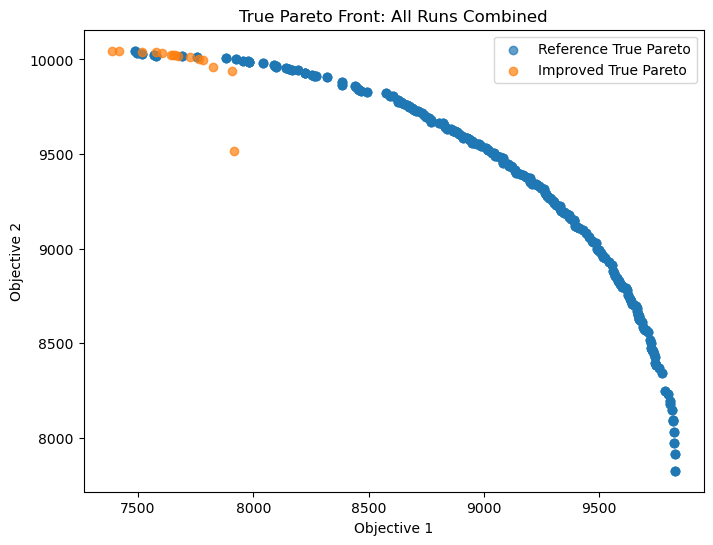

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("kss.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()

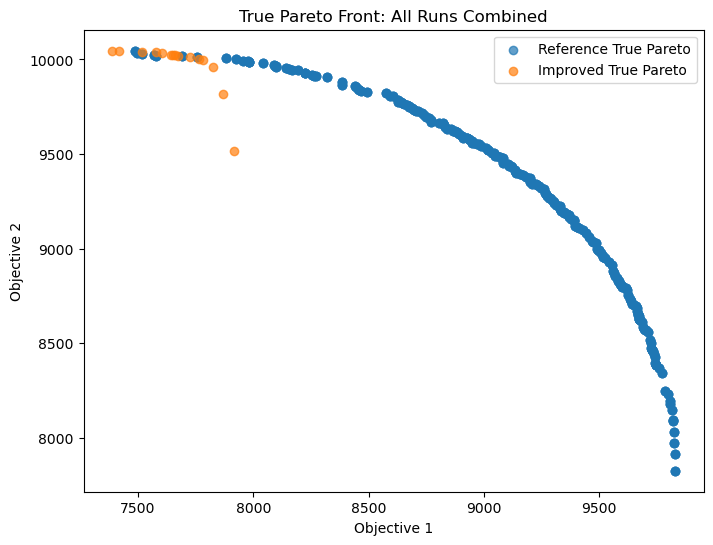

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("kss.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()

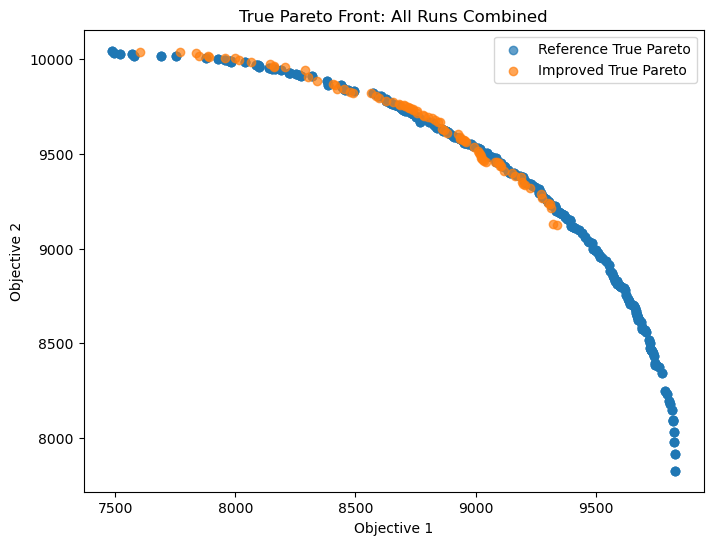

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("pssst1.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()

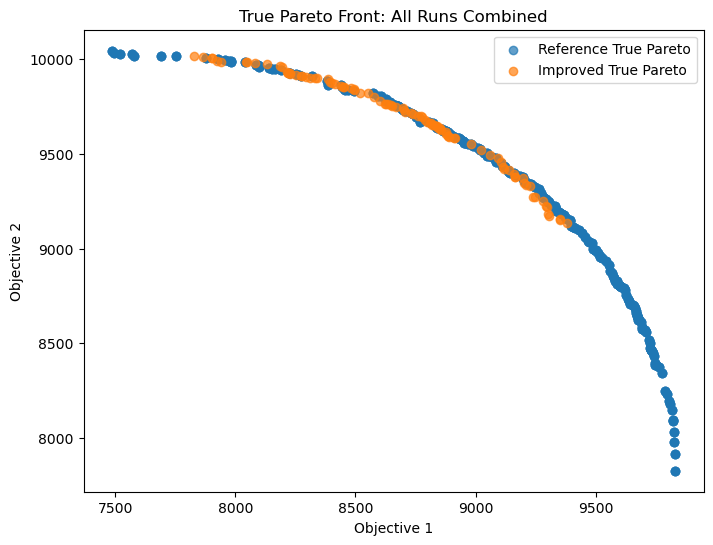

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("bro3.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()

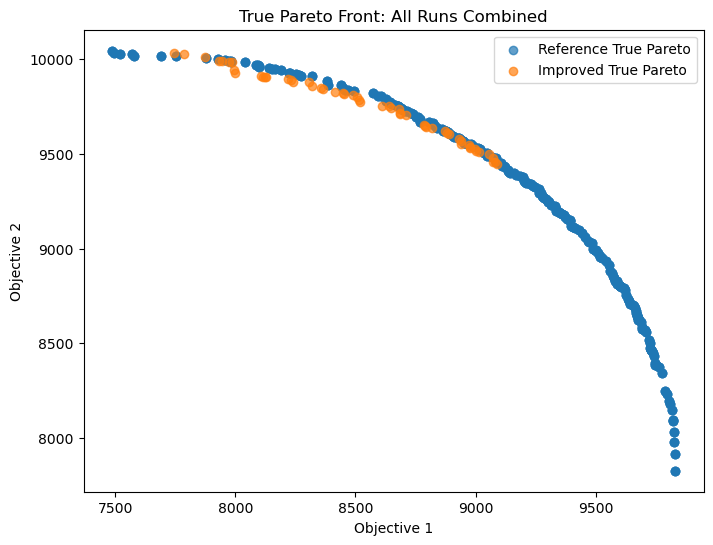

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("bro6.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()